# System Setup

In [1]:
%pip install -q datasets evaluate ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [33]:
%pip install -q wandb==0.17.2 matplotlib setuptools scikit-learn

Note: you may need to restart the kernel to use updated packages.


If running this notebook in Colab, please ensure that your Hugging Face `HF_TOKEN` and your Weights & Biases `WANDB_API_KEY` are added to your Colab secrets.

Alternatively, please login to Hugging Face and Weights & Biases by running the following two cells.

In [1]:
import os
import random
import numpy as np
import torch

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# Data Preparation

In [2]:
from datasets import load_dataset

fashion_mnist = load_dataset("zalando-datasets/fashion_mnist")
fashion_mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [3]:
features = fashion_mnist['train'].features
features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [4]:
id2label = {id: label for id, label in enumerate(features['label'].names)}
id2label

{0: 'T - shirt / top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [5]:
label2id = {label: id for id, label in id2label.items()}
label2id

{'T - shirt / top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [6]:
example = fashion_mnist['train'][0]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [7]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

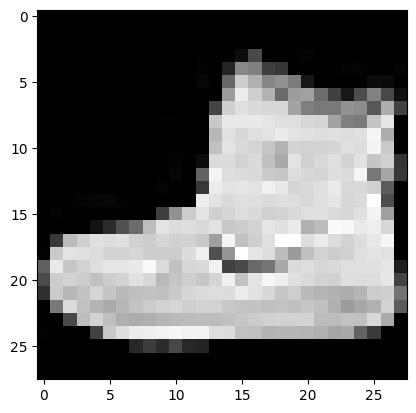

In [8]:
plt.imshow(example['image'], cmap='gray');

In [9]:
id2label[example['label']]

'Ankle boot'

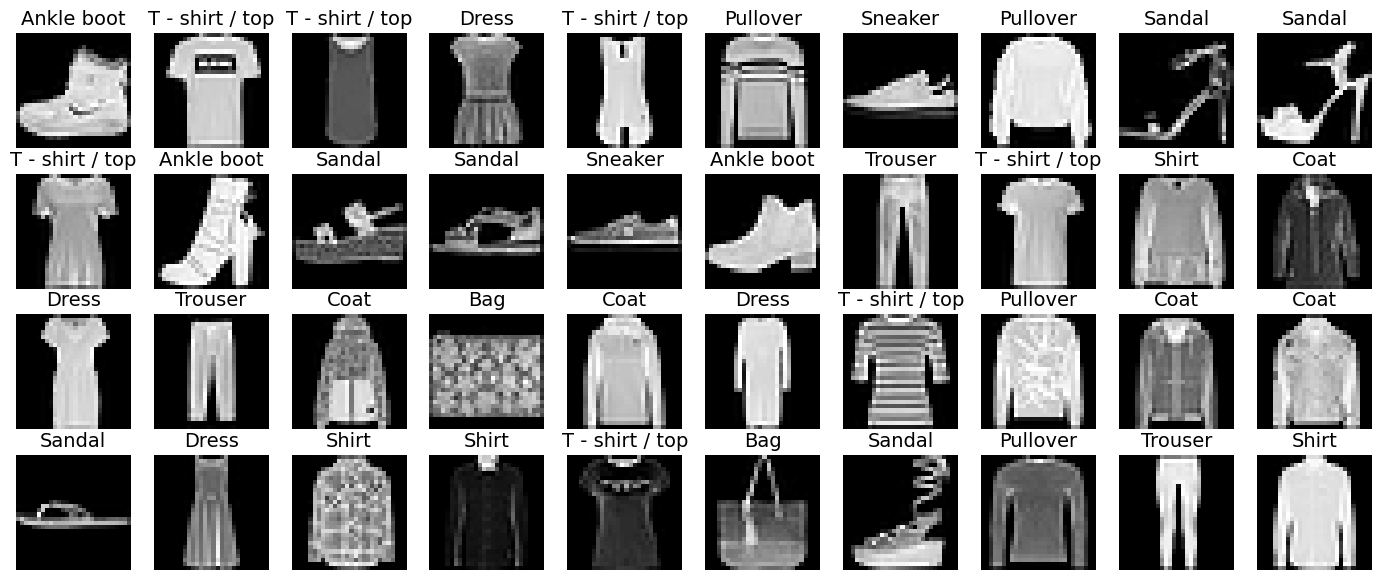

In [10]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.75, n_rows * 1.75))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        example = fashion_mnist['train'][index]
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(example['image'], cmap='gray')
        plt.axis('off')
        plt.title(id2label[example['label']])
plt.show()

In [11]:
train_ds = fashion_mnist['train'].select(range(55000))
valid_ds = fashion_mnist['train'].select(range(55000, 60000))
test_ds = fashion_mnist['test']
len(train_ds), len(valid_ds), len(test_ds)

(55000, 5000, 10000)

In [12]:
from torch.utils.data import Dataset, DataLoader

class FashionMNISTDataset(Dataset):
    def __init__(self, ds, tfms):
        self.ds = ds
        self.tfms = tfms

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        example = self.ds[idx]
        return self.tfms(example['image']), example['label']

In [13]:
import torchvision.transforms.v2 as v2

tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [14]:
train_set = FashionMNISTDataset(train_ds, tfms)
len(train_set)

55000

In [15]:
# Sanity check:
img, label = train_set[0]
img.shape, label

(torch.Size([1, 28, 28]), 9)

In [16]:
valid_set = FashionMNISTDataset(valid_ds, tfms)
test_set = FashionMNISTDataset(test_ds, tfms)
len(valid_set), len(test_set)

(5000, 10000)

In [17]:
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
len(train_loader)

859

In [18]:
# Sanity check:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [19]:
x_batch.dtype, y_batch.dtype

(torch.float32, torch.int64)

In [20]:
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
len(valid_loader), len(test_loader)

(78, 156)

# Futhark Model Loading

In [ ]:
# If you modified the futhark model, you will need to restart the kernel
# and re-run the notebook to get the updated model.

!rm -rf _model.* model.c model.h
!futhark multicore --library model.fut
!build_futhark_ffi model

In [21]:
import numpy as np
import _model
from futhark_ffi import Futhark

model = Futhark(_model)

In [22]:
import sys
sys.path.append("..")
from deeplearning_utils import parse_spec

In [23]:
# Get futhark model weights specification
spec = parse_spec(model.from_futhark(model.specs()))
spec

{'fc1.weight': {'tpe': 'f32', 'dims': [300, 784]},
 'fc1.bias': {'tpe': 'f32', 'dims': [300]},
 'fc2.weight': {'tpe': 'f32', 'dims': [100, 300]},
 'fc2.bias': {'tpe': 'f32', 'dims': [100]},
 'fc3.weight': {'tpe': 'f32', 'dims': [10, 100]},
 'fc3.bias': {'tpe': 'f32', 'dims': [10]}}

In [24]:
#from torch.optim import SGD

#learning_rate = 1e-2
#optimizer = SGD(model.parameters(), lr=learning_rate)
n_epochs = 30

In [25]:
from tqdm.autonotebook import tqdm, trange

def train_epoch(ws):
    #model.train()
    train_loss = 0
    #ws = mnist.init_weights()
    #TODO fixme to group batches as much as possible
    for x_batch, y_batch in tqdm(train_loader, desc="Training"):
        x_batch = x_batch.reshape((64, 28*28)).numpy()
        y_batch = y_batch.numpy()
        (ws, loss) = model.train(ws, batch_size, x_batch, y_batch)
        train_loss += loss
    train_loss /= len(train_set)
    train_loss = round(train_loss, 4)
    return (ws, train_loss)

In [26]:
def validate_epoch(ws):
    valid_loss = 0
    valid_acc = 0
    #TODO fixme to group batches as much as possible
    for x_batch, y_batch in tqdm(valid_loader, desc="Validation"):
        x_batch = x_batch.reshape((64, 28*28)).numpy()
        y_batch = y_batch.numpy()
        (acc, loss) = model.validate(ws, x_batch, y_batch)
        valid_loss += loss
        valid_acc += acc
    valid_loss /= len(valid_set)
    valid_loss = round(valid_loss, 4)
    valid_acc /= len(valid_set)/batch_size
    valid_acc = round(valid_acc, 4)
    return valid_loss, valid_acc

In [27]:
import wandb

wandb_config = {
    'architecture': "MLP",
    'dataset': "Fashion-MNIST",
    'batch_size': batch_size,
    'learning_rate': 0.01,
    'n_epochs': n_epochs
}
wandb.init(
    project="futhark-mlp-fashion-mnist",
    config=wandb_config,
    notes="Logging min of `train_loss` & `valid_loss`, and max of `accuracy`."
)
wandb.define_metric("train_loss", summary="min")
wandb.define_metric("valid_loss", summary="min")
wandb.define_metric("accuracy", summary="max")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: leonard-schneider. Use `wandb login --relogin` to force relogin
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core


In [28]:
from deeplearning_utils import push_to_HF_hub

best_epoch = 0
best_acc = 0
ws = model.default_weights()
for epoch in trange(n_epochs, desc="Epoch"):
    (ws, train_loss) = train_epoch(ws)

    valid_loss, acc = validate_epoch(ws)

    wandb.log({'train_loss': train_loss, 'valid_loss': valid_loss, 'accuracy': acc})

    tqdm.write(f"Epoch: {epoch}, Training Loss: {train_loss}, Validation Loss: {valid_loss}, Accuracy: {acc}")

    if acc > best_acc:
        best_epoch = epoch
        best_acc = acc
        push_to_HF_hub(
            model,
            "leoschneider/futhark-mlp-fashion-mnist",
            "model.fut",
            ws,
            commit_message=f"epoch: {epoch}, accuracy: {acc}",
            token=os.environ["HF_TOKEN"]
        )
wandb.finish()
print("---")
print("Done!")
print(f"Best Epoch: {best_epoch}, Best Accuracy: {best_acc}")

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 0, Training Loss: 0.8365, Validation Loss: 0.5684, Accuracy: 0.8022


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.5272, Validation Loss: 0.4784, Accuracy: 0.8326


No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.4726, Validation Loss: 0.44, Accuracy: 0.843


No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.4438, Validation Loss: 0.4232, Accuracy: 0.8432


No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.4233, Validation Loss: 0.4155, Accuracy: 0.8462


No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.4089, Validation Loss: 0.4111, Accuracy: 0.8506


No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.3943, Validation Loss: 0.3879, Accuracy: 0.857


No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.3854, Validation Loss: 0.4051, Accuracy: 0.851


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.3743, Validation Loss: 0.3798, Accuracy: 0.8562


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 0.3679, Validation Loss: 0.3762, Accuracy: 0.8594


No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 0.359, Validation Loss: 0.3611, Accuracy: 0.8662


No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 11, Training Loss: 0.3523, Validation Loss: 0.3658, Accuracy: 0.8662


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 12, Training Loss: 0.3455, Validation Loss: 0.3521, Accuracy: 0.8676


No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 13, Training Loss: 0.3403, Validation Loss: 0.3541, Accuracy: 0.8686


No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 14, Training Loss: 0.3346, Validation Loss: 0.3499, Accuracy: 0.867


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 15, Training Loss: 0.3281, Validation Loss: 0.3412, Accuracy: 0.8708


No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 16, Training Loss: 0.3241, Validation Loss: 0.3452, Accuracy: 0.8728


No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 17, Training Loss: 0.3193, Validation Loss: 0.3385, Accuracy: 0.8744


No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 18, Training Loss: 0.313, Validation Loss: 0.3499, Accuracy: 0.8688


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 19, Training Loss: 0.3101, Validation Loss: 0.3397, Accuracy: 0.8704


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 20, Training Loss: 0.305, Validation Loss: 0.3398, Accuracy: 0.874


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 21, Training Loss: 0.3002, Validation Loss: 0.3356, Accuracy: 0.872


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 22, Training Loss: 0.2975, Validation Loss: 0.349, Accuracy: 0.8714


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 23, Training Loss: 0.2943, Validation Loss: 0.3529, Accuracy: 0.8696


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 24, Training Loss: 0.2896, Validation Loss: 0.3388, Accuracy: 0.8742


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 25, Training Loss: 0.2855, Validation Loss: 0.3321, Accuracy: 0.8764


No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 26, Training Loss: 0.2827, Validation Loss: 0.3257, Accuracy: 0.8772


No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 27, Training Loss: 0.2794, Validation Loss: 0.3171, Accuracy: 0.8794


No files have been modified since last commit. Skipping to prevent empty commit.


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 28, Training Loss: 0.2752, Validation Loss: 0.3274, Accuracy: 0.8776


Training:   0%|          | 0/859 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 29, Training Loss: 0.272, Validation Loss: 0.3241, Accuracy: 0.878


wandb: WARNING Unable to render Widget, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core


---
Done!
Best Epoch: 27, Best Accuracy: 0.8794


**Note:** Early stopping with a patience of 5 epochs would have been a bad idea here.

In [36]:
import importlib
importlib.reload(sys.modules['deeplearning_utils'])

<module 'deeplearning_utils' from '/Users/leonardschneider/Library/Mobile Documents/com~apple~CloudDocs/deeplearning/programs/fashion-mnist/../deeplearning_utils.py'>

In [37]:
# Load model from HF hub, if you want to skip training
from deeplearning_utils import load_weights_from_hf_hub

ws = load_weights_from_hf_hub(
    model,
    "leoschneider/futhark-mlp-fashion-mnist",
    "model.safetensors",
    token=os.environ["HF_TOKEN"]
)

model.safetensors:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

In [48]:
test_acc = 0
for x_batch, y_batch in tqdm(test_loader, desc="Test"):
    x_batch = x_batch.reshape((64, 28*28)).numpy()
    y_batch = y_batch.numpy()
    (acc, _) = model.validate(ws, x_batch, y_batch)
    test_acc += acc
test_acc /= len(test_set)/batch_size
test_acc = round(test_acc, 4)
print(f"Test Set Accuracy: {test_acc}")

Test:   0%|          | 0/156 [00:00<?, ?it/s]

Test Set Accuracy: 0.8753


Let's use the model to predict on a new test set image:

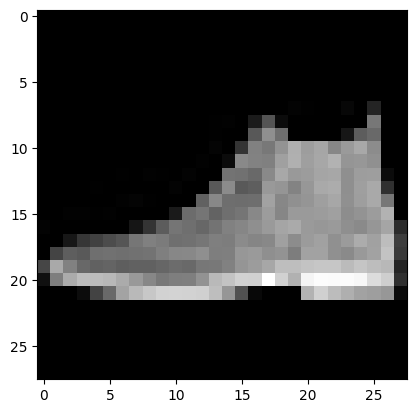

In [40]:
example = test_ds[0]
plt.imshow(example['image'], cmap='gray');

In [41]:
id2label[example['label']]

'Ankle boot'

In [42]:
img = tfms(example['image'])
img.shape

torch.Size([1, 28, 28])

In [46]:
pred = model.from_futhark(model.predict(ws, img.reshape(1, 28*28).numpy()))
pred

array([9], dtype=int32)

In [47]:
id2label[pred[0]]

'Ankle boot'